Imports:

In [28]:
import numpy as np
import pandas as pd  
import data_cleaning_for_EDA as dc 
import matplotlib.pyplot as plt
import seaborn as sns
import imputing_methods as im
# from imputing_methods import Plotter, DataFrameTransform
# from data_cleaning_for_EDA import DataFrameInfo 

Read in data: 

In [2]:
def parse_to_datetime_mo_yr(date_str):
    return pd.to_datetime(date_str, format='%b-%Y', errors='coerce') 

# Reading in the csv and parsing dates. 
finance_df = pd.read_csv(
    "dataframe.csv",
    parse_dates=['issue_date', 'earliest_credit_line', 'last_payment_date', 'next_payment_date', 'last_credit_pull_date'],
    date_format='%m-%Y',
    converters={'issue_date': parse_to_datetime_mo_yr, 
                'earliest_credit_line': parse_to_datetime_mo_yr,
                'last_payment_date': parse_to_datetime_mo_yr,
                'next_payment_date': parse_to_datetime_mo_yr,
                'last_credit_pull_date': parse_to_datetime_mo_yr}
)
# Cleaning up lengths of time that could be treated as floats. 
finance_df['employment_length'] = finance_df['employment_length'].str.extract(r"([-+]?\d*\.\d+|[-+]?\d+)").astype(float)
finance_df['term'] = finance_df['term'].str.extract(r"([-+]?\d*\.\d+|[-+]?\d+)").astype(float)
finance_df.rename(columns = {'employment_length':'years_of_employment', 'term' : 'term_length_in_months'}, inplace = True) 
# Cleaning up object type columns- all of which are suitable for category (I checked).
columns_to_cat = ['grade', 'sub_grade', 'verification_status', 'home_ownership', 'loan_status', 'payment_plan', 'purpose', 'application_type']
finance_df[columns_to_cat] = finance_df[columns_to_cat].astype('category')

Allowing my data frame to inherit any classes I've created and want to use: 

In [16]:
class MultipleInheritanceTestClass(im.Plotter, im.DataFrameTransform, dc.DataFrameInfo):
    pass

df = MultipleInheritanceTestClass(finance_df)

Main Workspace: 

In [4]:
# Before: 
df.perc_null()

Unnamed: 0                      0.000000
id                              0.000000
member_id                       0.000000
loan_amount                     0.000000
funded_amount                   5.544799
funded_amount_inv               0.000000
term_length_in_months           8.799395
int_rate                        9.531449
instalment                      0.000000
grade                           0.000000
sub_grade                       0.000000
years_of_employment             3.905515
home_ownership                  0.000000
annual_inc                      0.000000
verification_status             0.000000
issue_date                      0.000000
loan_status                     0.000000
payment_plan                    0.000000
purpose                         0.000000
dti                             0.000000
delinq_2yrs                     0.000000
earliest_credit_line            0.000000
inq_last_6mths                  0.000000
mths_since_last_delinq         57.166565
mths_since_last_

In [ ]:
df.drop_weak_columns() 
df.perc_null()


Decide whether the column should be imputed with median or mean: 

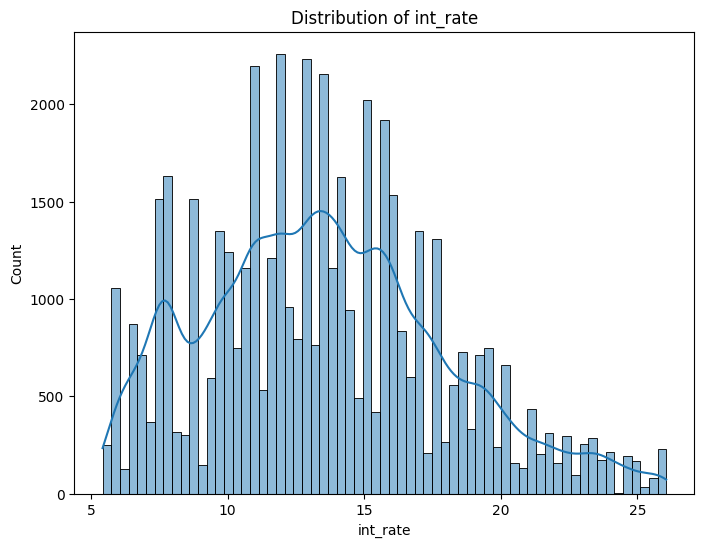

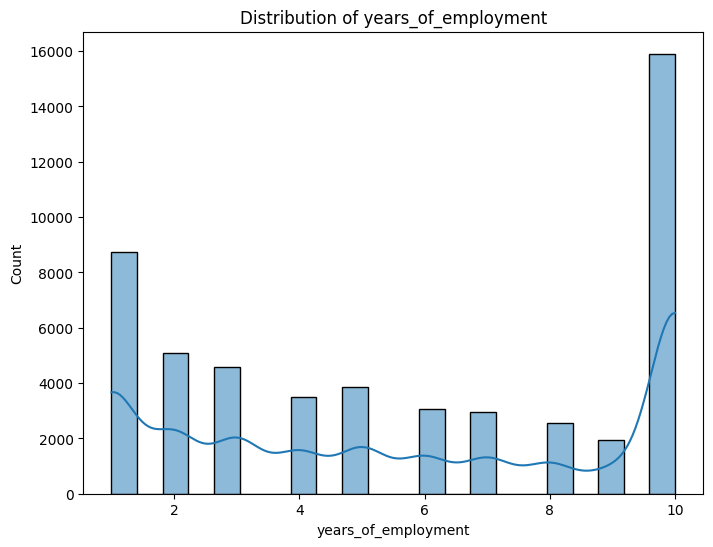

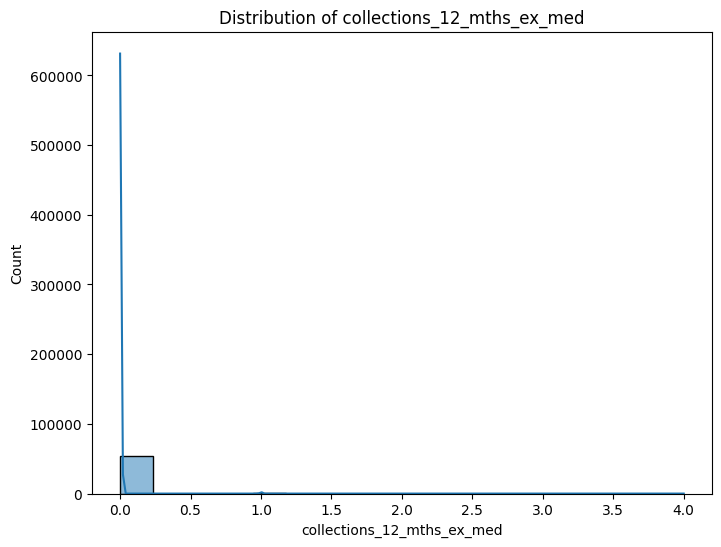

In [6]:
#I ran plots for all five of the non-zero percentage null columns, but I kept pressing shift+enter so moved on with my life; you can see three here and run the other three yourself if you want. 
df.plot_column("int_rate")
df.plot_column("years_of_employment")
df.plot_column("collections_12_mths_ex_med")
#they're all skewed so all median imputes

Impute null values:

In [11]:
df.impute_null_values()
df.perc_null() # All 0s now, as should be. 

Unnamed: 0                    0.0
id                            0.0
member_id                     0.0
loan_amount                   0.0
funded_amount                 0.0
funded_amount_inv             0.0
term_length_in_months         0.0
int_rate                      0.0
instalment                    0.0
grade                         0.0
sub_grade                     0.0
years_of_employment           0.0
home_ownership                0.0
annual_inc                    0.0
verification_status           0.0
issue_date                    0.0
loan_status                   0.0
payment_plan                  0.0
purpose                       0.0
dti                           0.0
delinq_2yrs                   0.0
earliest_credit_line          0.0
inq_last_6mths                0.0
open_accounts                 0.0
total_accounts                0.0
out_prncp                     0.0
out_prncp_inv                 0.0
total_payment                 0.0
total_payment_inv             0.0
total_rec_prnc

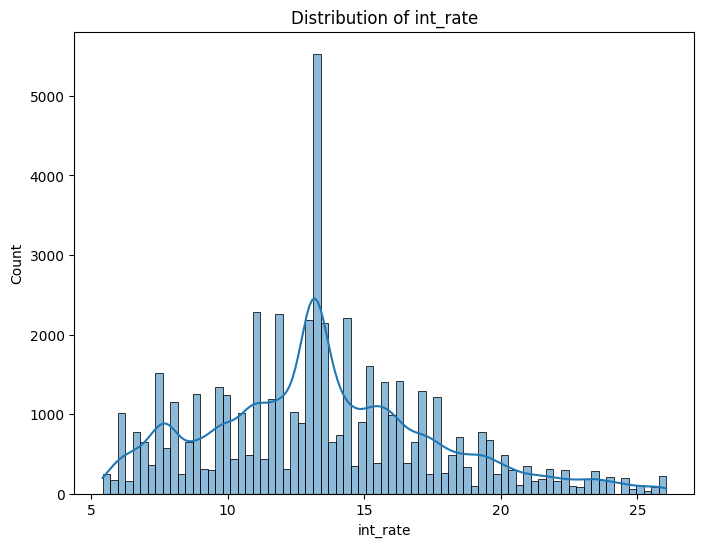

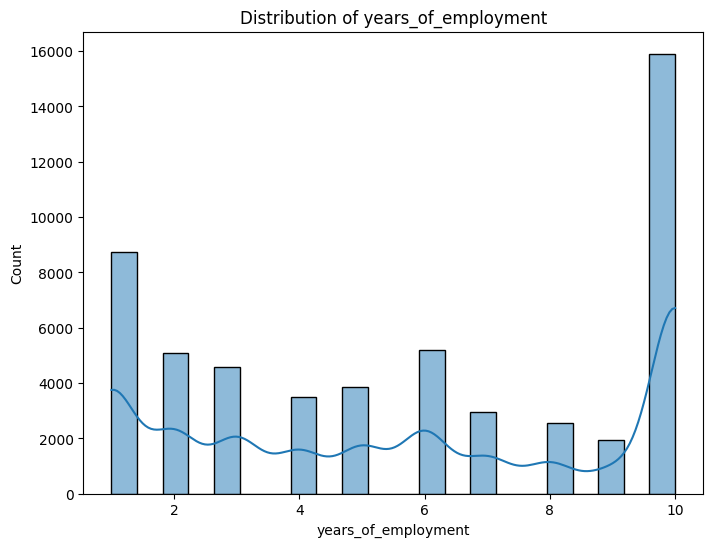

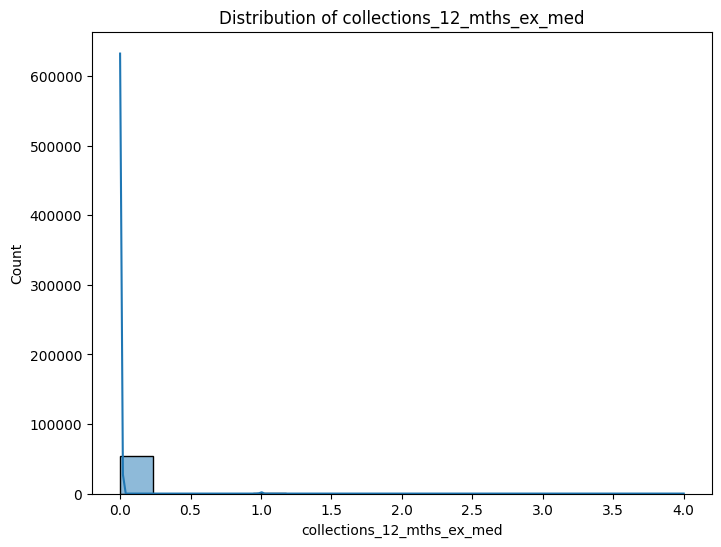

In [8]:
#visualise the removal of null values with another plot: 
df.plot_column("int_rate")
df.plot_column("years_of_employment")
df.plot_column("collections_12_mths_ex_med")
#As expected, now major spikes at point of median-- this would increase kurtosis. 

Task 4: Dealing with Skew. 

In [36]:
#Preamble (speedrun through Task 3 on startup)
# 1. Run imports 
# 2. Read-in finance_df 

class MultipleInheritanceTestClass(im.Plotter, im.DataFrameTransform, dc.DataFrameInfo):
    pass

df = MultipleInheritanceTestClass(finance_df)
df.drop_weak_columns() 
df.impute_null_values() 

Step 1: Identify skewed columns in data using Pandas methods; determine a threshold for skewness. 

I've created a high_skew_columns method in data_clening_for_EDA. It should give any columns with skew greater than 1.2 (default threshold). 

In [4]:
# finance_df.skew(numeric_only=True)
df.high_skew_columns() # With a threshold of 1.2, this yielded: 
'''
['id',
 'member_id',
 'annual_inc',
 'delinq_2yrs',
 'inq_last_6mths',
 'out_prncp',
 'out_prncp_inv',
 'total_payment',
 'total_payment_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_payment_amount',
 'collections_12_mths_ex_med'] 
'''


['id',
 'member_id',
 'annual_inc',
 'delinq_2yrs',
 'inq_last_6mths',
 'out_prncp',
 'out_prncp_inv',
 'total_payment',
 'total_payment_inv',
 'total_rec_prncp',
 'total_rec_int',
 'total_rec_late_fee',
 'recoveries',
 'collection_recovery_fee',
 'last_payment_amount',
 'collections_12_mths_ex_med']


Rule of thumb off the internet is a skew of abs val 1 is "uncomfortable." Let's see what those look like. 

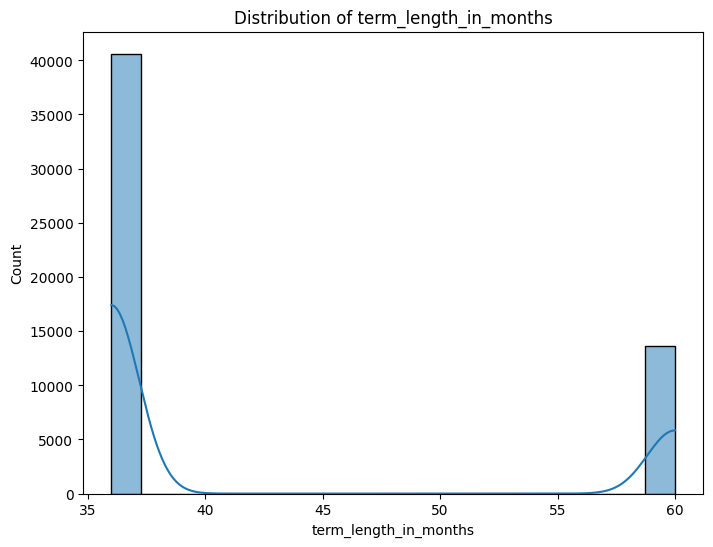

In [20]:
df.plot_column("term_length_in_months") #skew of 1 and this is the "binary" one I imputed with the median so it now has a ratio of about 8:3... pretty heavily skewed! 

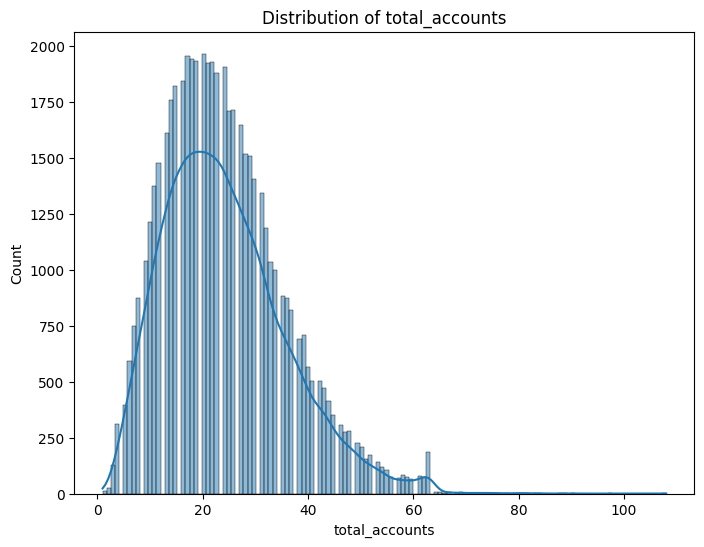

In [24]:
df.plot_column("total_accounts") # skewness of about 0.8 apparently. Looks like a Normal Distribution with just some extra tail on the top end. 

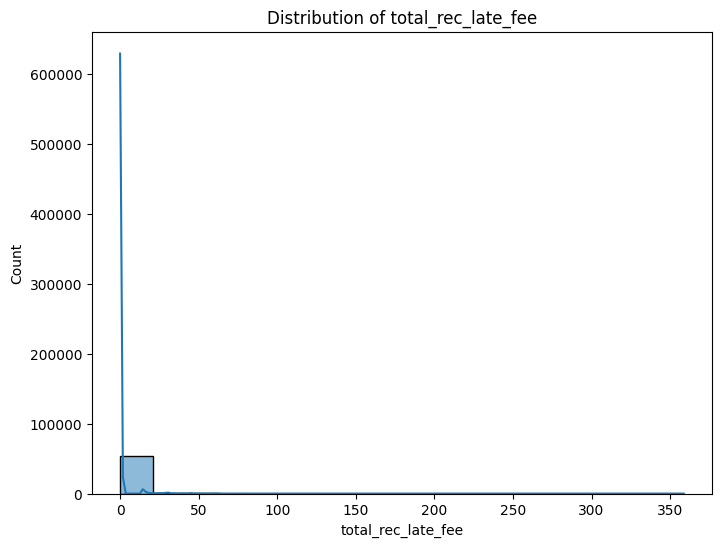

In [21]:
df.plot_column("total_rec_late_fee") #skewness of 13 - graph basically looks like it has just one outcome -- very skewed. 

Step 2: Once the skewed columns are identified, perform transformations no these columns to determine which transformation results in the biggest reduction in skew. 
Create a method to transform columns in DataFrameTransform class. 

As advised by Mat from AiCore, and detailed further here (https://anatomisebiostats.com/biostatistics-blog/transforming-skewed-data/), I've identified the following may be appropriate transformations: 

- log: potentially appropriate for high, positive skew. the larger the base (e.g. e vs 10), the higher the original degree of skewness. 
    - reciprocal: Mat didn't mention this, but it may be appropriate for extreme positive skewness. 
- yeo-johnson: Potentially appropriate for positively skewed data. 
- box-cox: For positively skewed, exclusively positive data. 
- square root: potentially appropriate for moderate, positive skew. 
- cube root: potentially appropriate for negatively skewed data. 
    - square: potential for negative skew. (again, this was suggested not by Mat but by https://medium.com/@TheDataGyan/day-8-data-transformation-skewness-normalization-and-much-more-4c144d370e55.)

I need to be able visualise these transformations one at a time before I commit them to transforming any given column. Therefore, I'll:
1. Add a transformation attribute to the plot_column() method. 
2. Add a printout of the skew values to the high_skew_columns() method. 

Plot of 'id' with identity transformation:


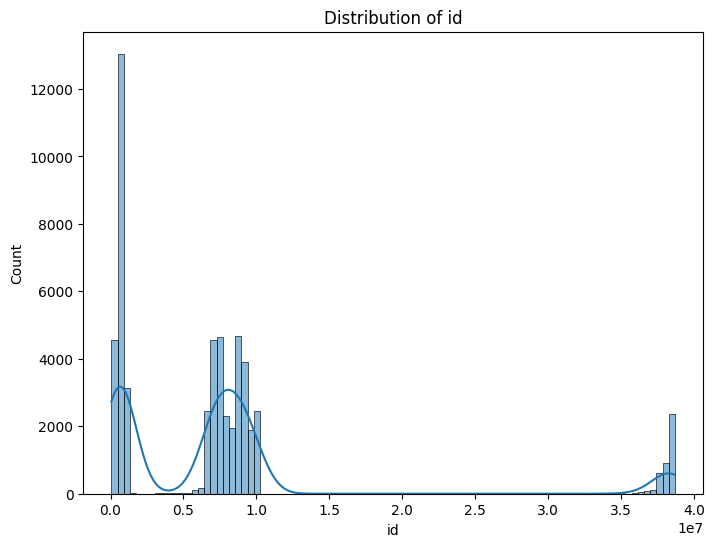

Plot of 'member_id' with identity transformation:


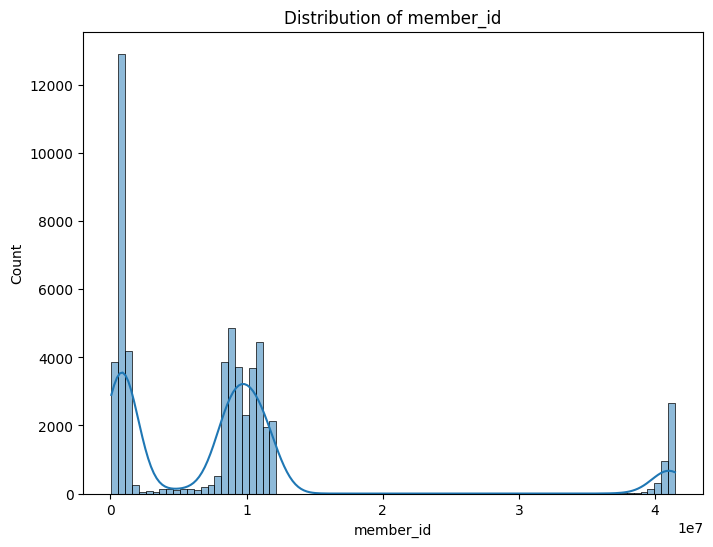

Plot of 'annual_inc' with identity transformation:


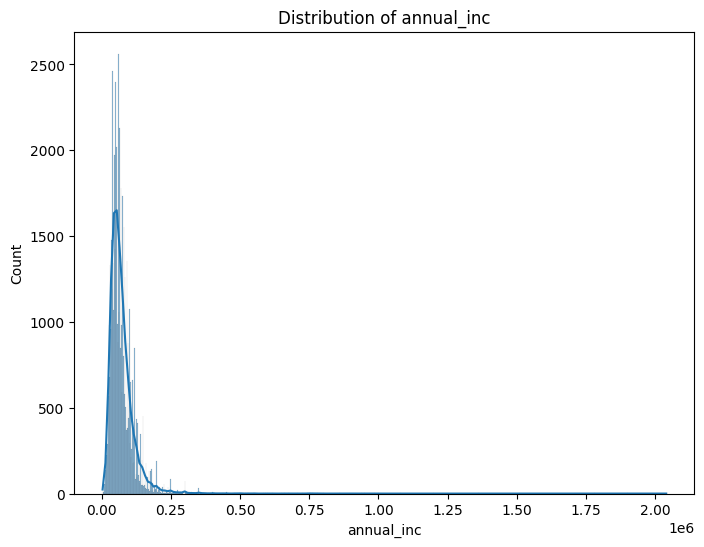

Plot of 'delinq_2yrs' with identity transformation:


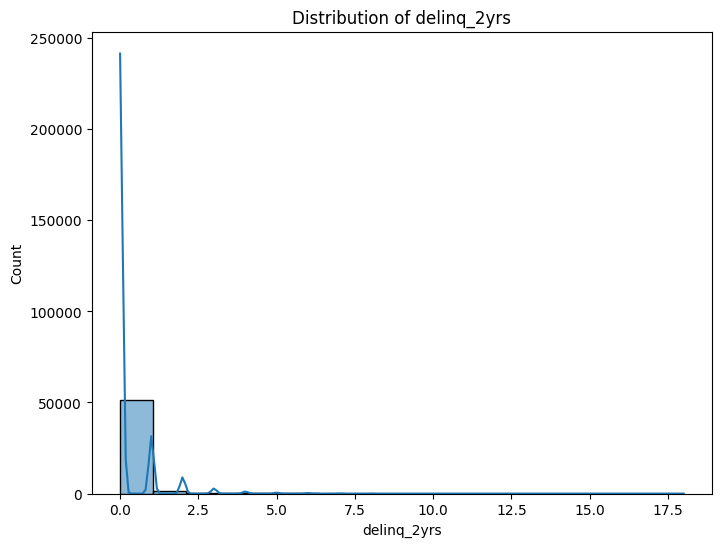

Plot of 'inq_last_6mths' with identity transformation:


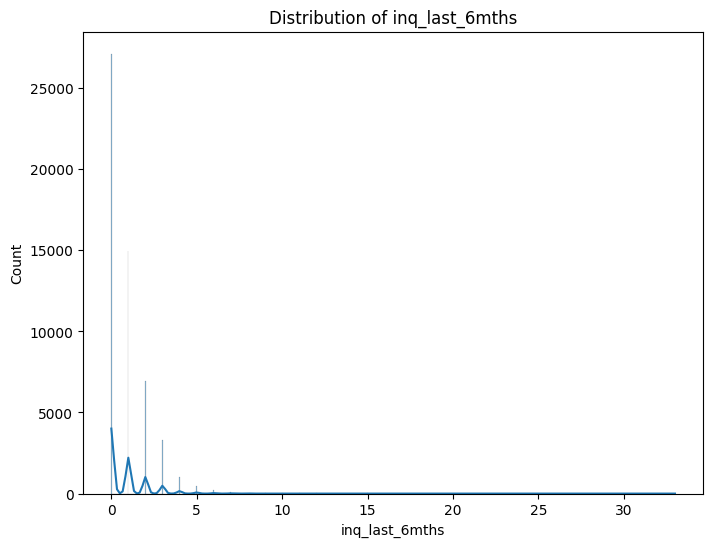

Plot of 'out_prncp' with identity transformation:


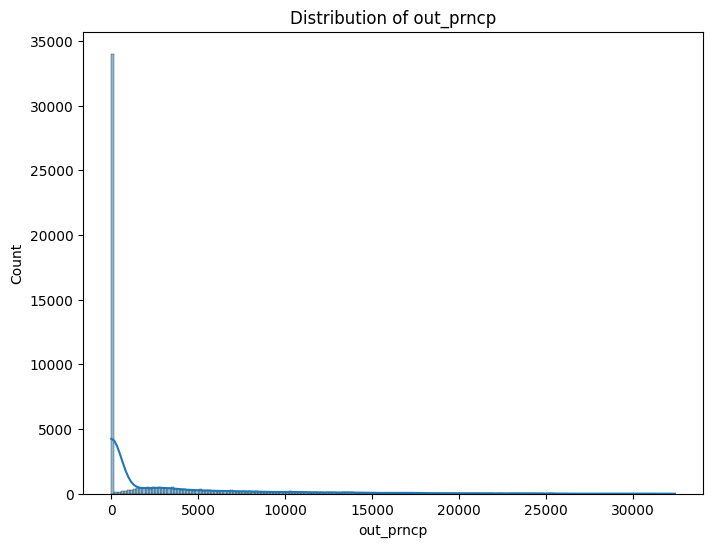

Plot of 'out_prncp_inv' with identity transformation:


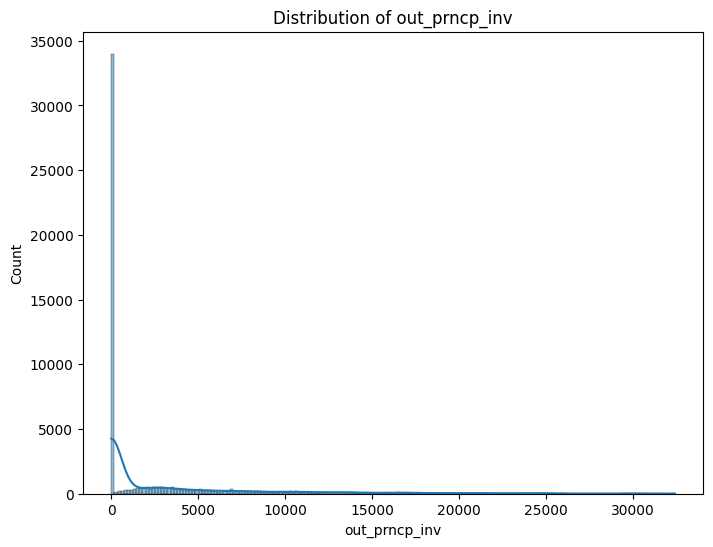

Plot of 'total_payment' with identity transformation:


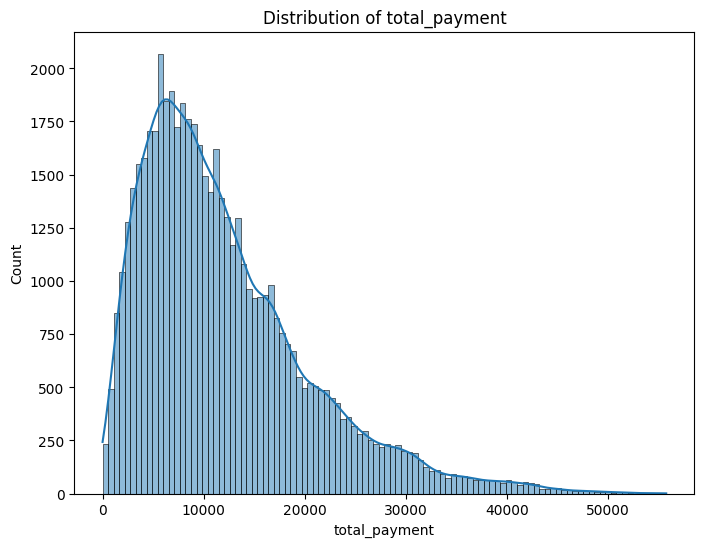

Plot of 'total_payment_inv' with identity transformation:


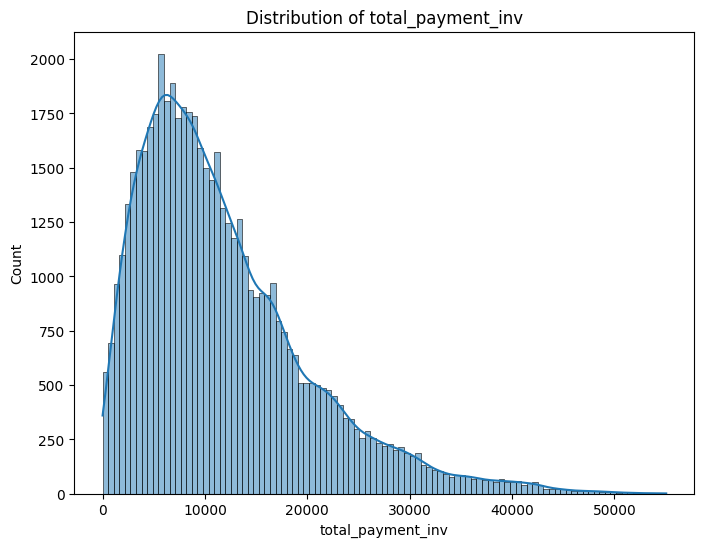

Plot of 'total_rec_prncp' with identity transformation:


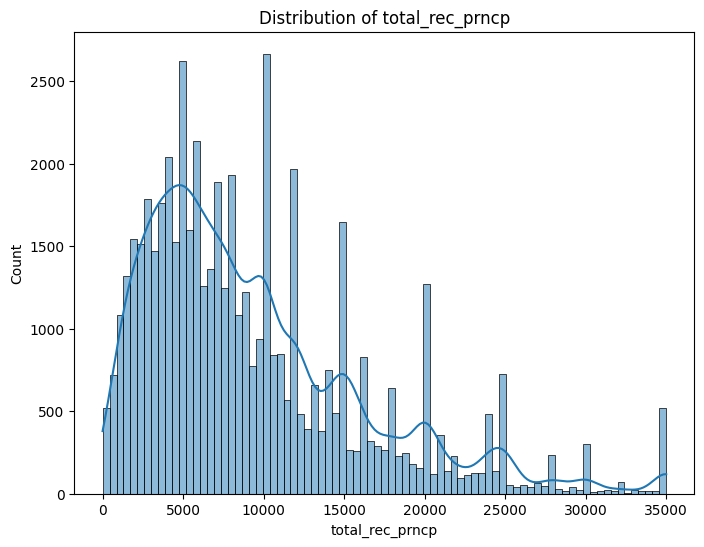

Plot of 'total_rec_int' with identity transformation:


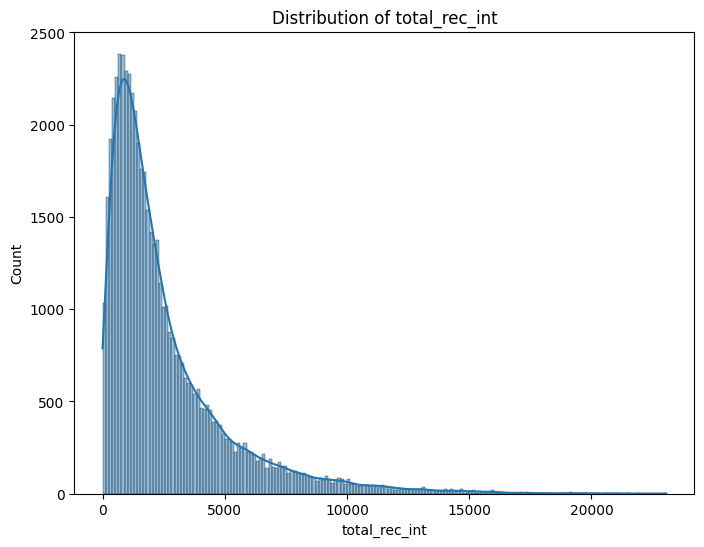

Plot of 'total_rec_late_fee' with identity transformation:


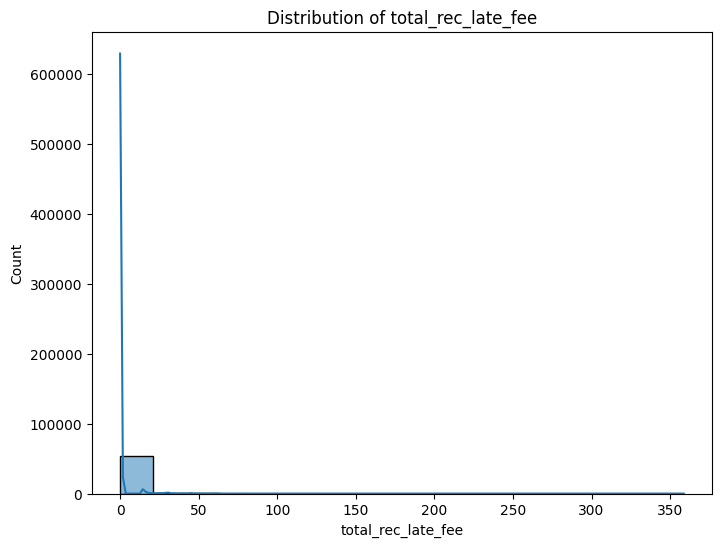

Plot of 'recoveries' with identity transformation:


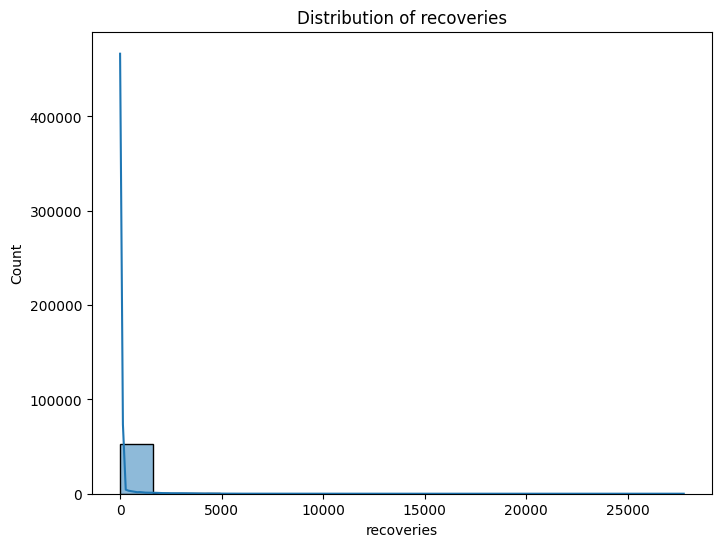

Plot of 'collection_recovery_fee' with identity transformation:


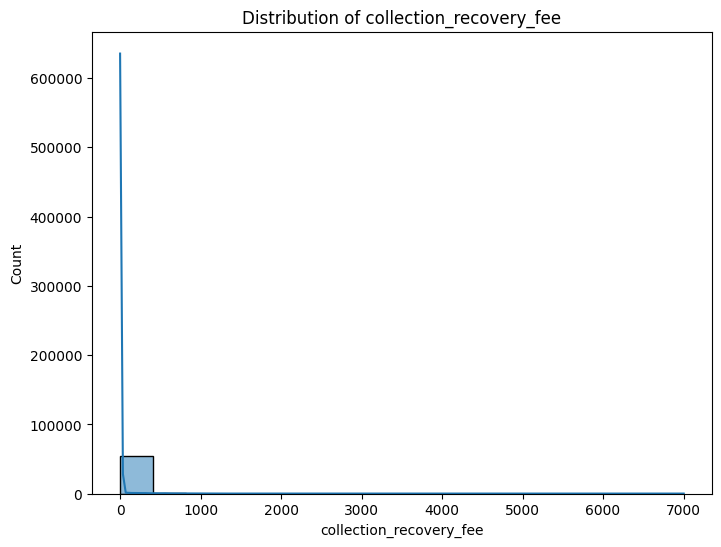

Plot of 'last_payment_amount' with identity transformation:


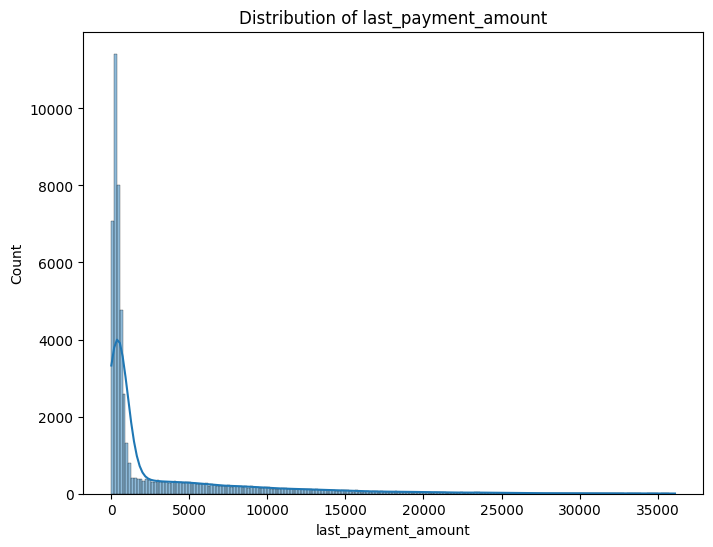

Plot of 'collections_12_mths_ex_med' with identity transformation:


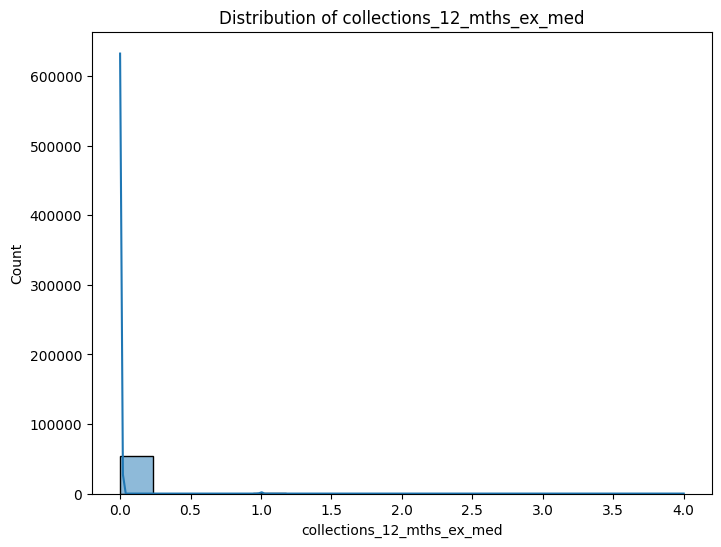

In [9]:
# Look at all the high-skew plots. 
high_skew_list = df.high_skew_columns()
for column_instance in high_skew_list: 
    print(f"Plot of '{column_instance}' with identity transformation:")
    df.plot_column(column_instance)

From the plots above we can visually confirm that all the highly skewed columns are right skewed, with skewnesses ranging from moderate (1.26) to crazy extreme (27.64). On the basis of the degree of skewness I will try a few of the following transformations, visualising in plotter before commmitting them to data transformation. Since all major skews were positive, I can rule out the transformations better suited to negative skews. All the key data is non-negative but I can't rule out values of zero. I can select the transformation on the basis of strength of original skewness: 
- moderate positive skew: square root
- high positive skew: natural log 
- higher positive skew: log base 10 
- even higher positive skew: log base 100
- extreme positive skew: reciprocal 

In [30]:
sqrt_transform = lambda x: pd.Series(x).apply(lambda val: val if val < 0 else np.sqrt(val)) #negatives shouldn't be an issue, but just in case... 
ln_transform = lambda x: pd.Series(x).apply(lambda val: val if val <= 0 else np.log(val)) # log 0 doesn't work either. 
log10_transform = lambda x: pd.Series(x).apply(lambda val: val if val <= 0 else np.log10(val))
log100_transform = lambda x: pd.Series(x).apply(lambda val: val if val <= 0 else np.log(val)/np.log(100)) #numpy doesn't default to log base 100, so need to use log rules. 
recip_transform = lambda x: pd.Series(x).apply(lambda val: val if val == 0 else np.reciprocal(val)) # reciprocal always exists, except at 0


Now I'll apply those tranformations and evaluate their prospects according to the list in finance_df.skew().txt (soon to appear in this repo).

Starting with the skewiest: 

C:\Users\user\AppData\Local\Temp\ipykernel_8092\1982525246.py:5: RuntimeWarning: divide by zero encountered in reciprocal
  recip_transform = lambda x: pd.Series(x).apply(lambda val:  np.reciprocal(val)) # reciprocal always exists


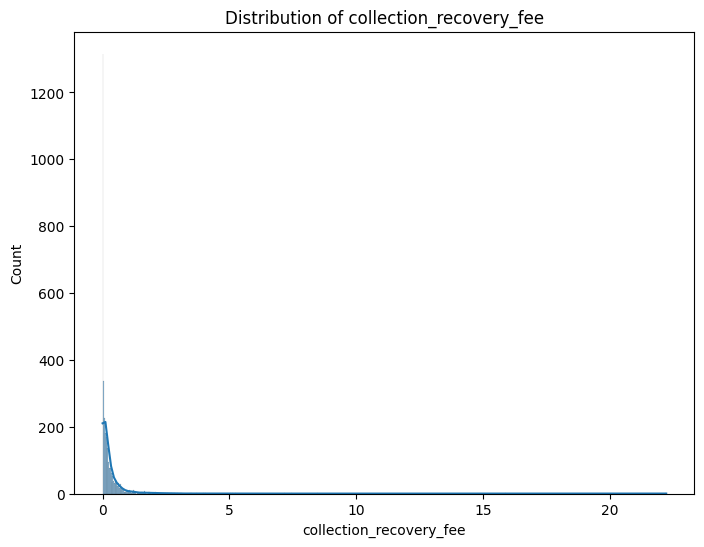

In [6]:
df.plot_column(column_name="collection_recovery_fee", transformer = recip_transform)

The reciprocal made almost no dent on collection_recovery_fee! Let's try log100: 

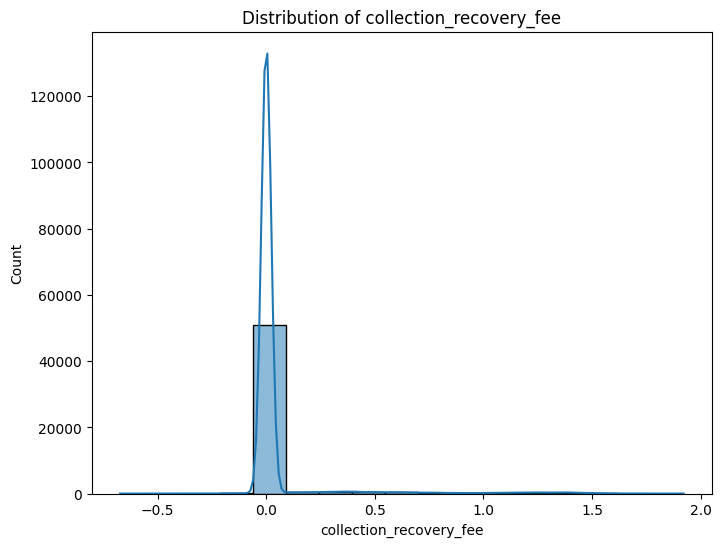

In [9]:
df.plot_column(column_name="collection_recovery_fee", transformer = log100_transform) # that looks better 

Next up I'll try the reciprocal and log100 on total_rec_late_fee (skew =13), recoveries (skew = 14), and collections_12_mths_ex_med (skew 20). 

Plot of 'total_rec_late_fee' with reciprocal transformation:


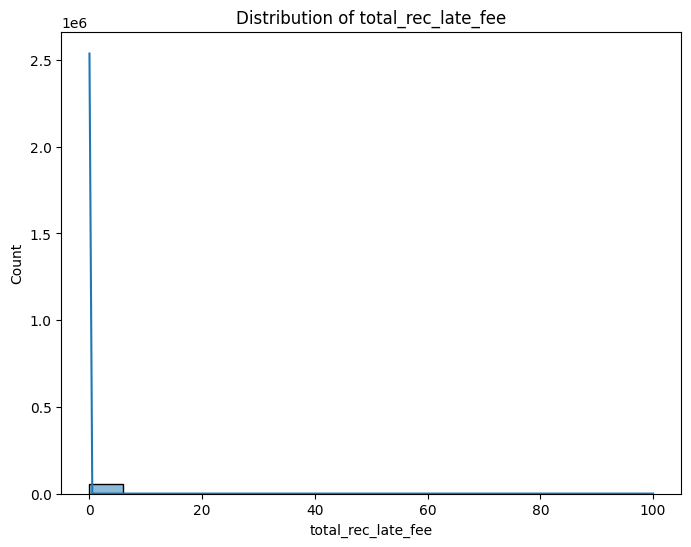

Plot of 'total_rec_late_fee' with log100 transformation:


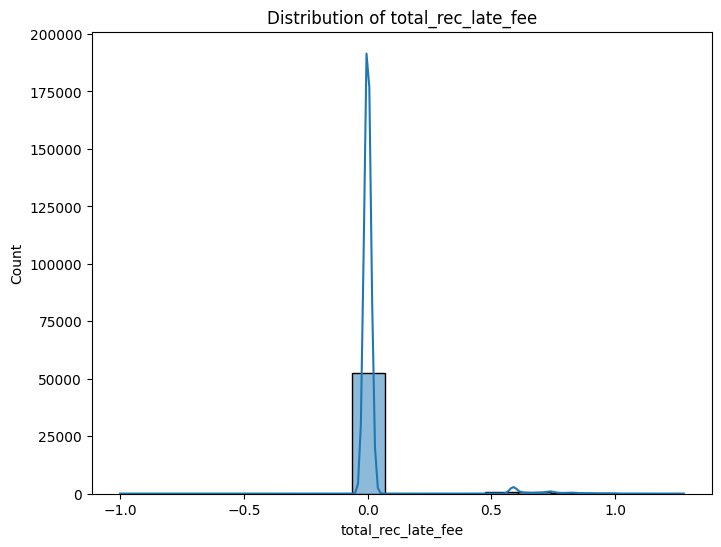

Plot of 'recoveries' with reciprocal transformation:


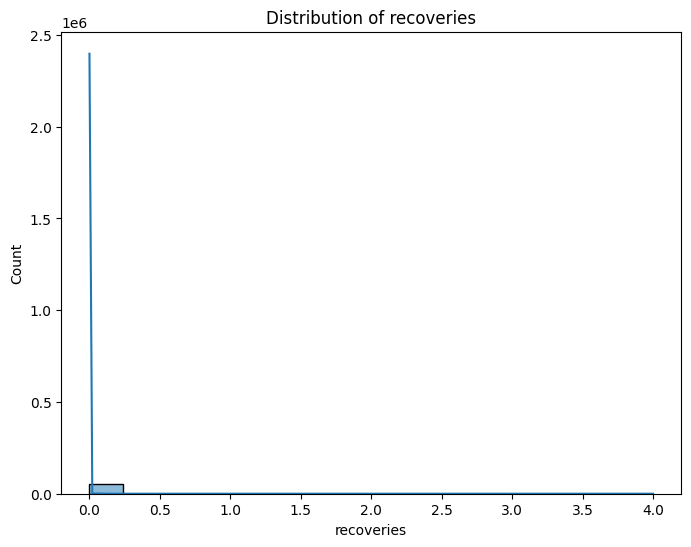

Plot of 'recoveries' with log100 transformation:


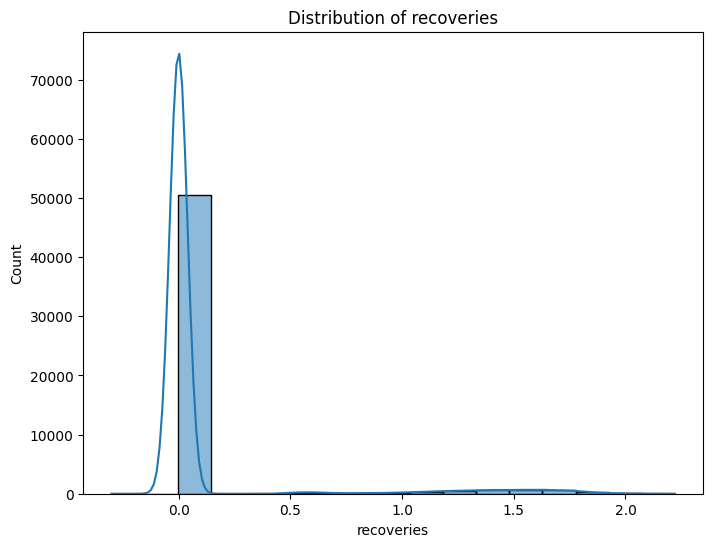

Plot of 'collections_12_mths_ex_med' with reciprocal transformation:


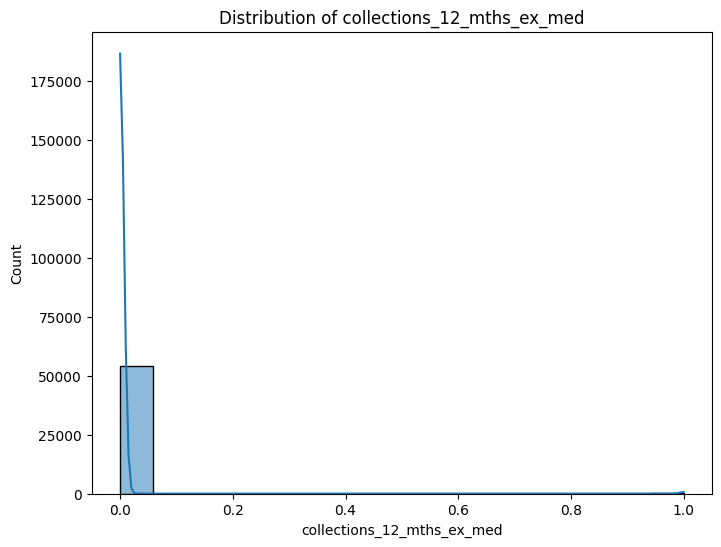

Plot of 'collections_12_mths_ex_med' with log100 transformation:


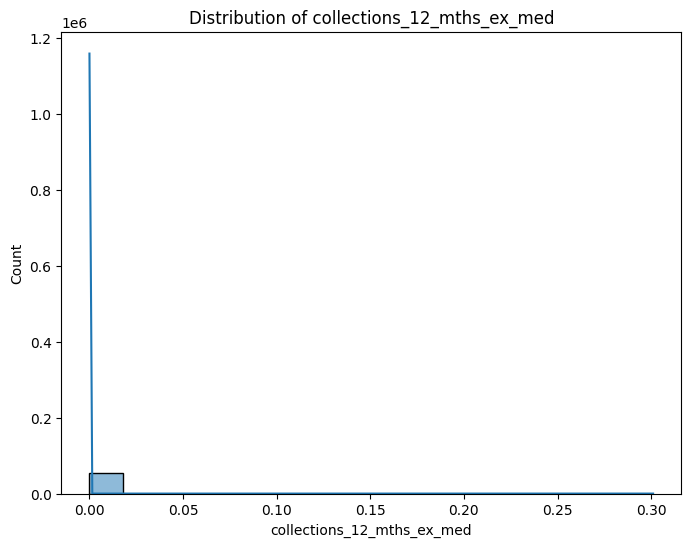

In [16]:
high_3_skews = {"total_rec_late_fee", "recoveries", "collections_12_mths_ex_med"}
for column_instance in high_3_skews:
    print(f"Plot of '{column_instance}' with reciprocal transformation:")
    df.plot_column(column_instance, transformer= recip_transform)
    print(f"Plot of '{column_instance}' with log100 transformation:")
    df.plot_column(column_instance, transformer= log100_transform)

Selections have been made for the above, see .txt file. 
Now onto the high, but not as high skews: annual_inc (skew = 8.7), deling_2yrs (5.4), inq_last_6mths (3.2)


Plot of 'annual_inc' with log10 transformation:


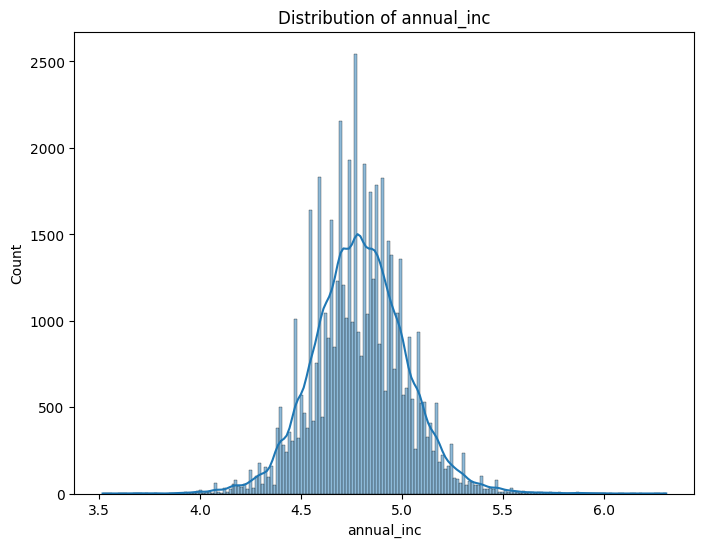

Plot of 'annual_inc' with log100 transformation:


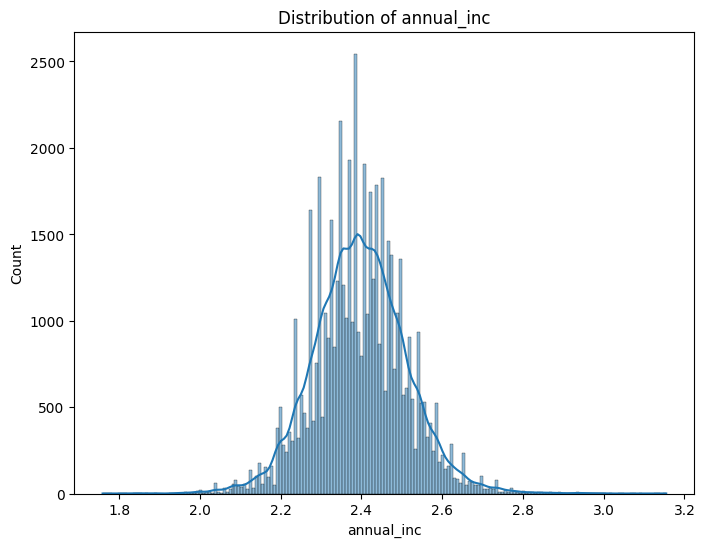

Plot of 'delinq_2yrs' with log10 transformation:


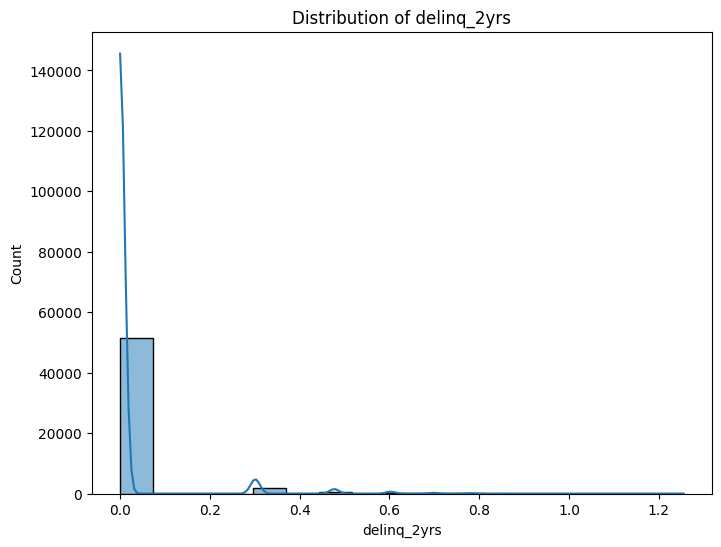

Plot of 'delinq_2yrs' with log100 transformation:


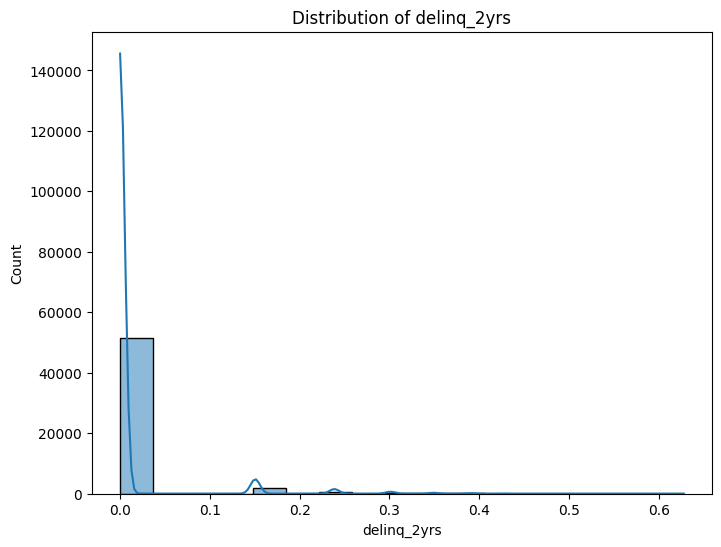

Plot of 'inq_last_6mths' with log10 transformation:


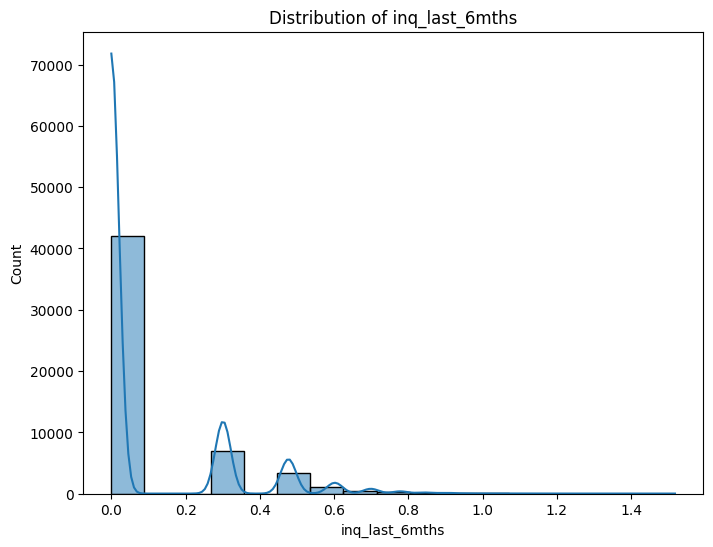

Plot of 'inq_last_6mths' with log100 transformation:


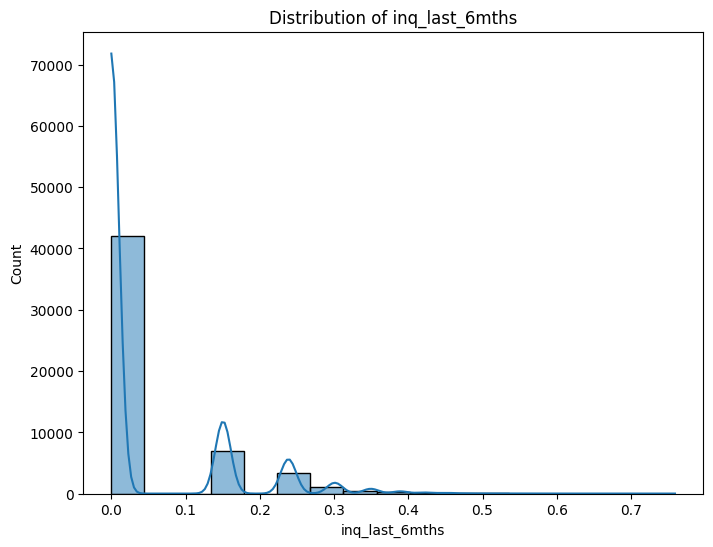

In [18]:
mid_high_skews = {"annual_inc", "delinq_2yrs", "inq_last_6mths"}
for column_instance in mid_high_skews:
    print(f"Plot of '{column_instance}' with log10 transformation:")
    df.plot_column(column_instance, transformer= log10_transform)
    print(f"Plot of '{column_instance}' with log100 transformation:")
    df.plot_column(column_instance, transformer= log100_transform)

It was after the above plots that I noticed the log transformations are identical barring their scale, which should not effect skewness. Thus, whether I apply log10 or log100 (or ln) should make no difference to the skewness of the transformed data. An alternative transformation I could have tried was the yeo-johnson transformation but I'm running low on time so I skipped it for now, but I recognise I could have used it (from https://towardsdatascience.com/types-of-transformations-for-better-normal-distribution-61c22668d3b9 : 

scipy.stats import yeojohnson
yf_target, lam = yeojohnson(df["TARGET"]) 

). 

Moving on... 
Then there were loads in the 2-3 range: last_payment_amount, total_rec_int, out_prncp_inv, out_prncp, member_id, id (these last two aren't relevant, as they are ids, not measures of anything in particular). Bear in mind that the dual displays for log10 and ln below should be identical for each column, if my understanding is correct. 

Plot of 'out_prncp_inv' with log10 transformation:


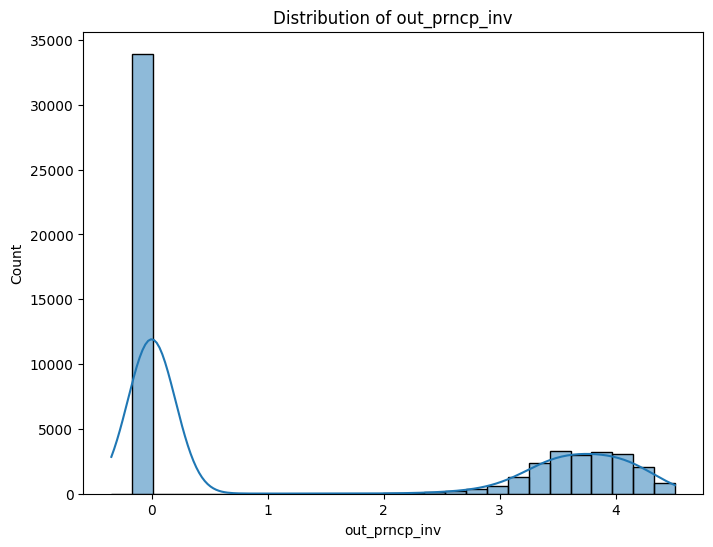

Plot of 'out_prncp_inv' with ln transformation:


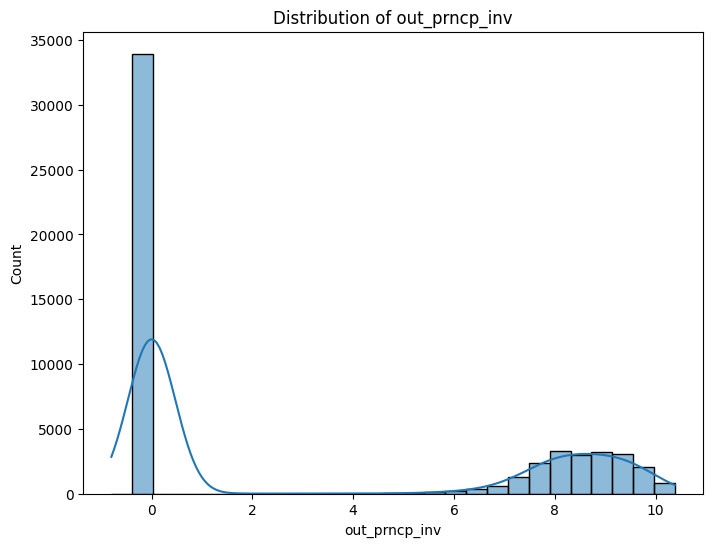

Plot of 'out_prncp' with log10 transformation:


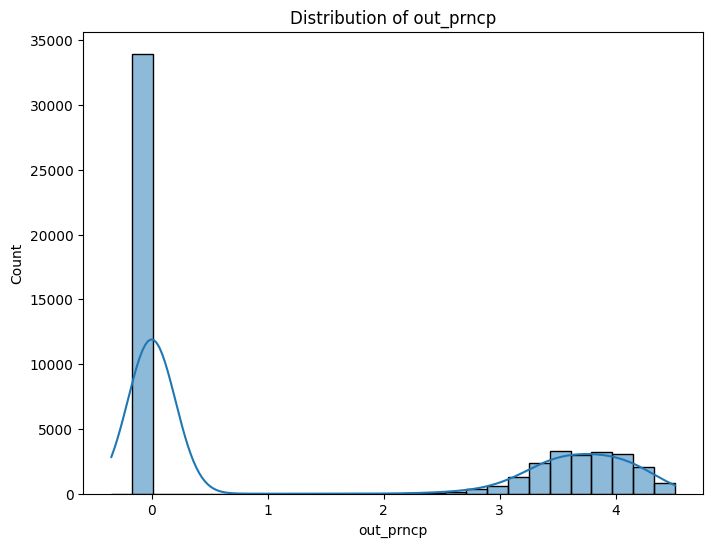

Plot of 'out_prncp' with ln transformation:


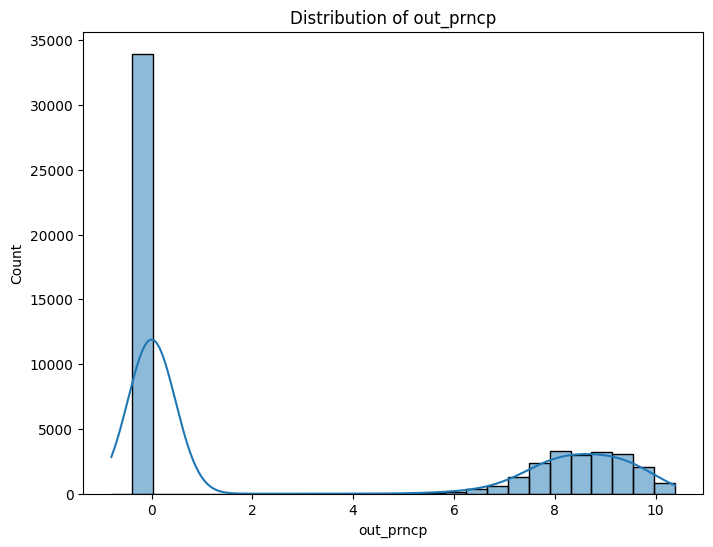

Plot of 'total_rec_int' with log10 transformation:


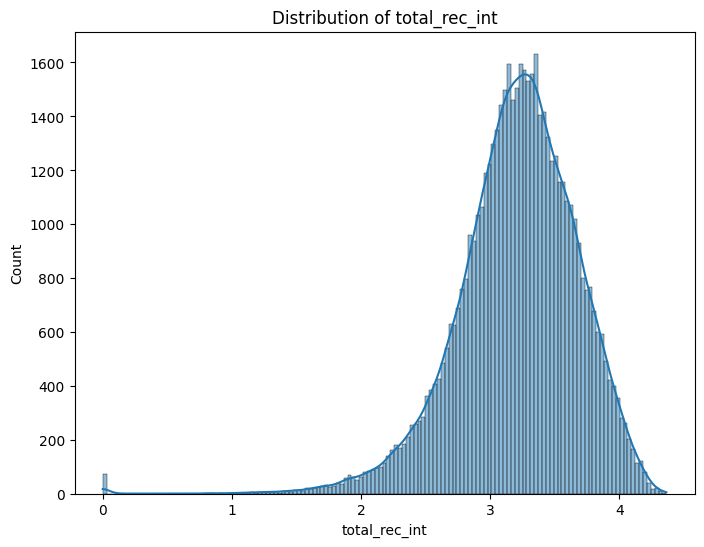

Plot of 'total_rec_int' with ln transformation:


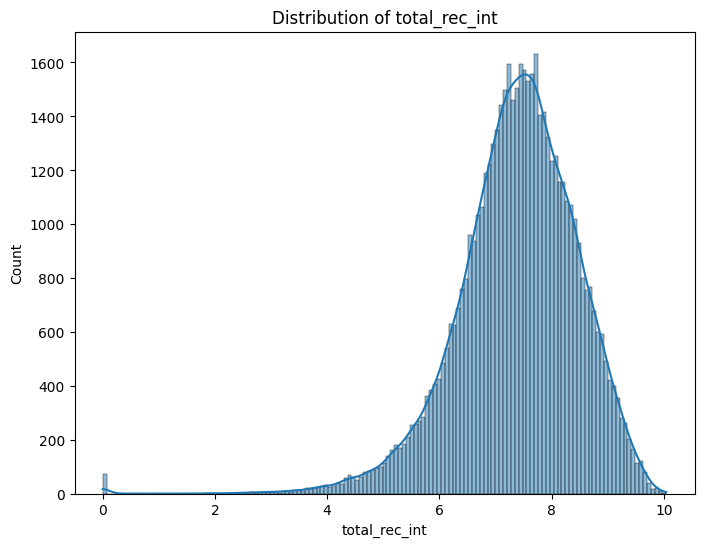

Plot of 'last_payment_amount' with log10 transformation:


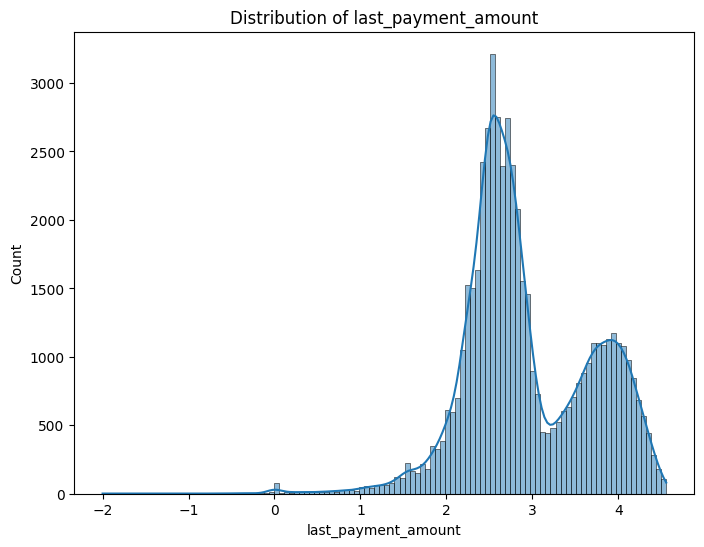

Plot of 'last_payment_amount' with ln transformation:


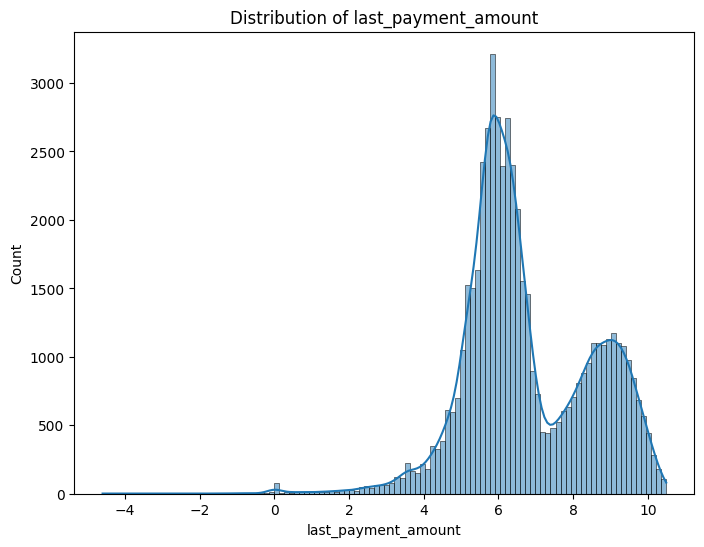

In [19]:
mid_skews = {"last_payment_amount", "total_rec_int", "out_prncp_inv", "out_prncp"}
for column_instance in mid_skews:
    print(f"Plot of '{column_instance}' with log10 transformation:")
    df.plot_column(column_instance, transformer= log10_transform)
    print(f"Plot of '{column_instance}' with ln transformation:")
    df.plot_column(column_instance, transformer= ln_transform)


Though the graphs look identical across relative scales, the internet assures me that skew is affected differently by different sizes of log base. 

Finally there were the skews greater than 1.2 but less than 2: total_payment, total_payment_inv, total_rec_prncp 

Plot of 'total_payment' with sqrt transformation:


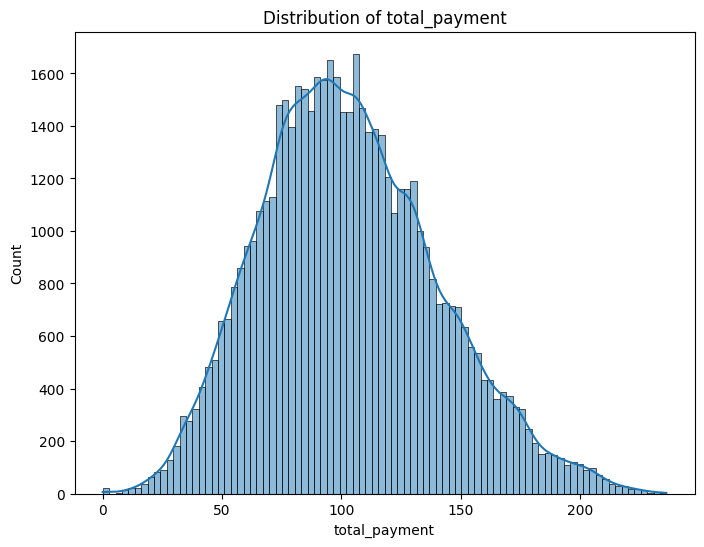

Plot of 'total_payment' with ln transformation:


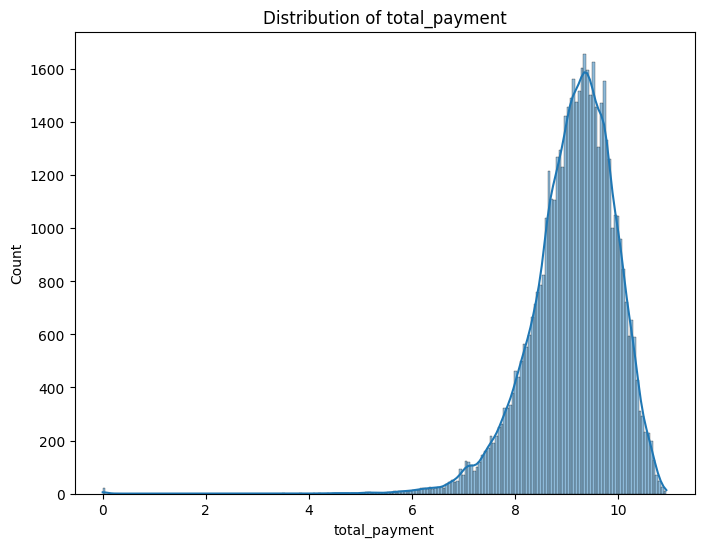

Plot of 'total_payment_inv' with sqrt transformation:


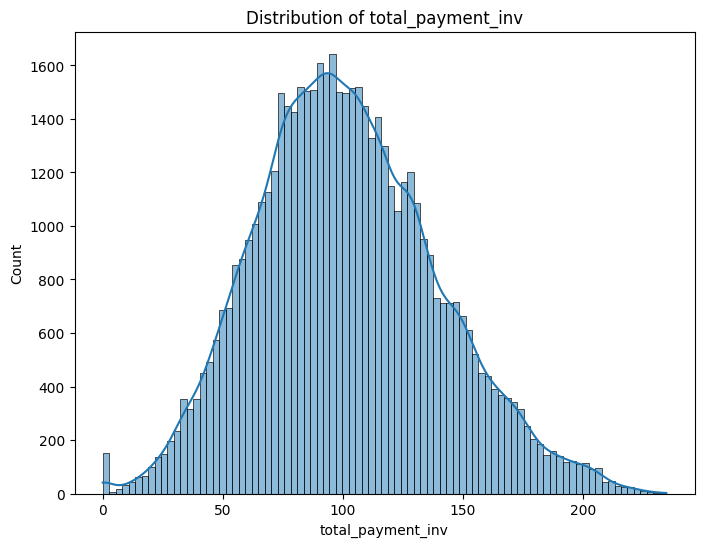

Plot of 'total_payment_inv' with ln transformation:


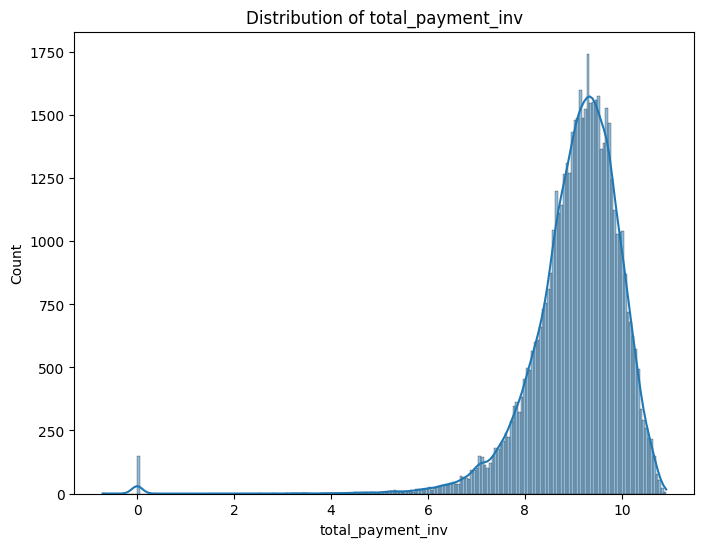

Plot of 'total_rec_prncp' with sqrt transformation:


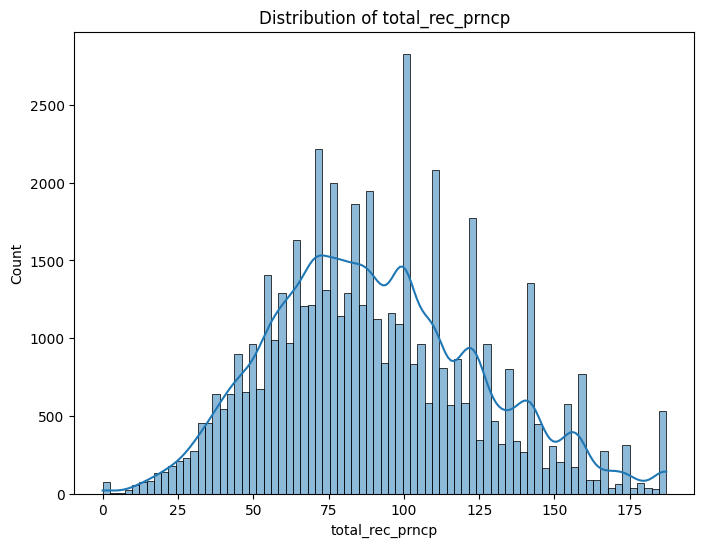

Plot of 'total_rec_prncp' with ln transformation:


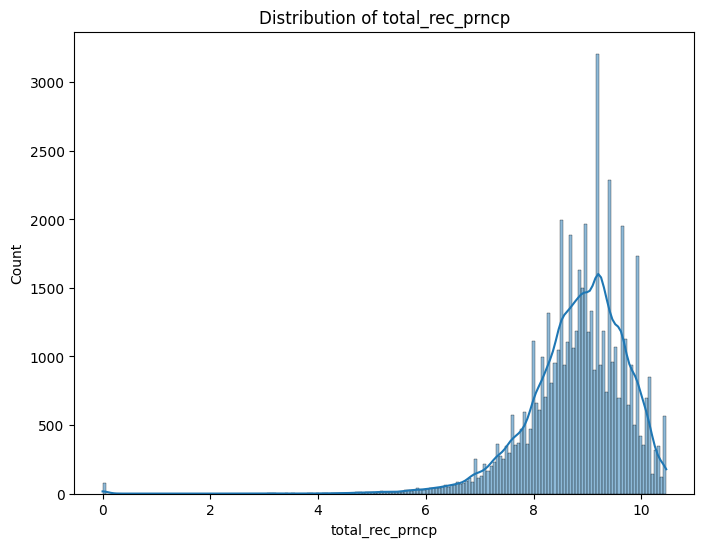

In [20]:
moderate_skews = {"total_payment","total_payment_inv", "total_rec_prncp"}
for column_instance in moderate_skews:
    print(f"Plot of '{column_instance}' with sqrt transformation:")
    df.plot_column(column_instance, transformer= sqrt_transform)
    print(f"Plot of '{column_instance}' with ln transformation:")
    df.plot_column(column_instance, transformer= ln_transform)

Try transforming all those columns: 

In [37]:
#the following selected from finance_df.skew().txt: 
columns_to_fix = df.high_skew_columns()[2:] # drop the id numbers 
# print(columns_to_fix) # confirmed the above did what i wanted 
transforms_to_apply = [log10_transform, log10_transform, log10_transform, log10_transform, log10_transform, sqrt_transform, sqrt_transform, sqrt_transform, ln_transform, log100_transform, log100_transform, log100_transform, log10_transform, recip_transform]

# I have confirmed that both of the above are lists. 

# print(len(columns_to_fix), len(transforms_to_apply)) # of the same length: 14 and 14

df.skew_transform(columns_to_fix, transforms_to_apply)

TypeError: DataFrameTransform.skew_transform() takes 1 positional argument but 3 were given